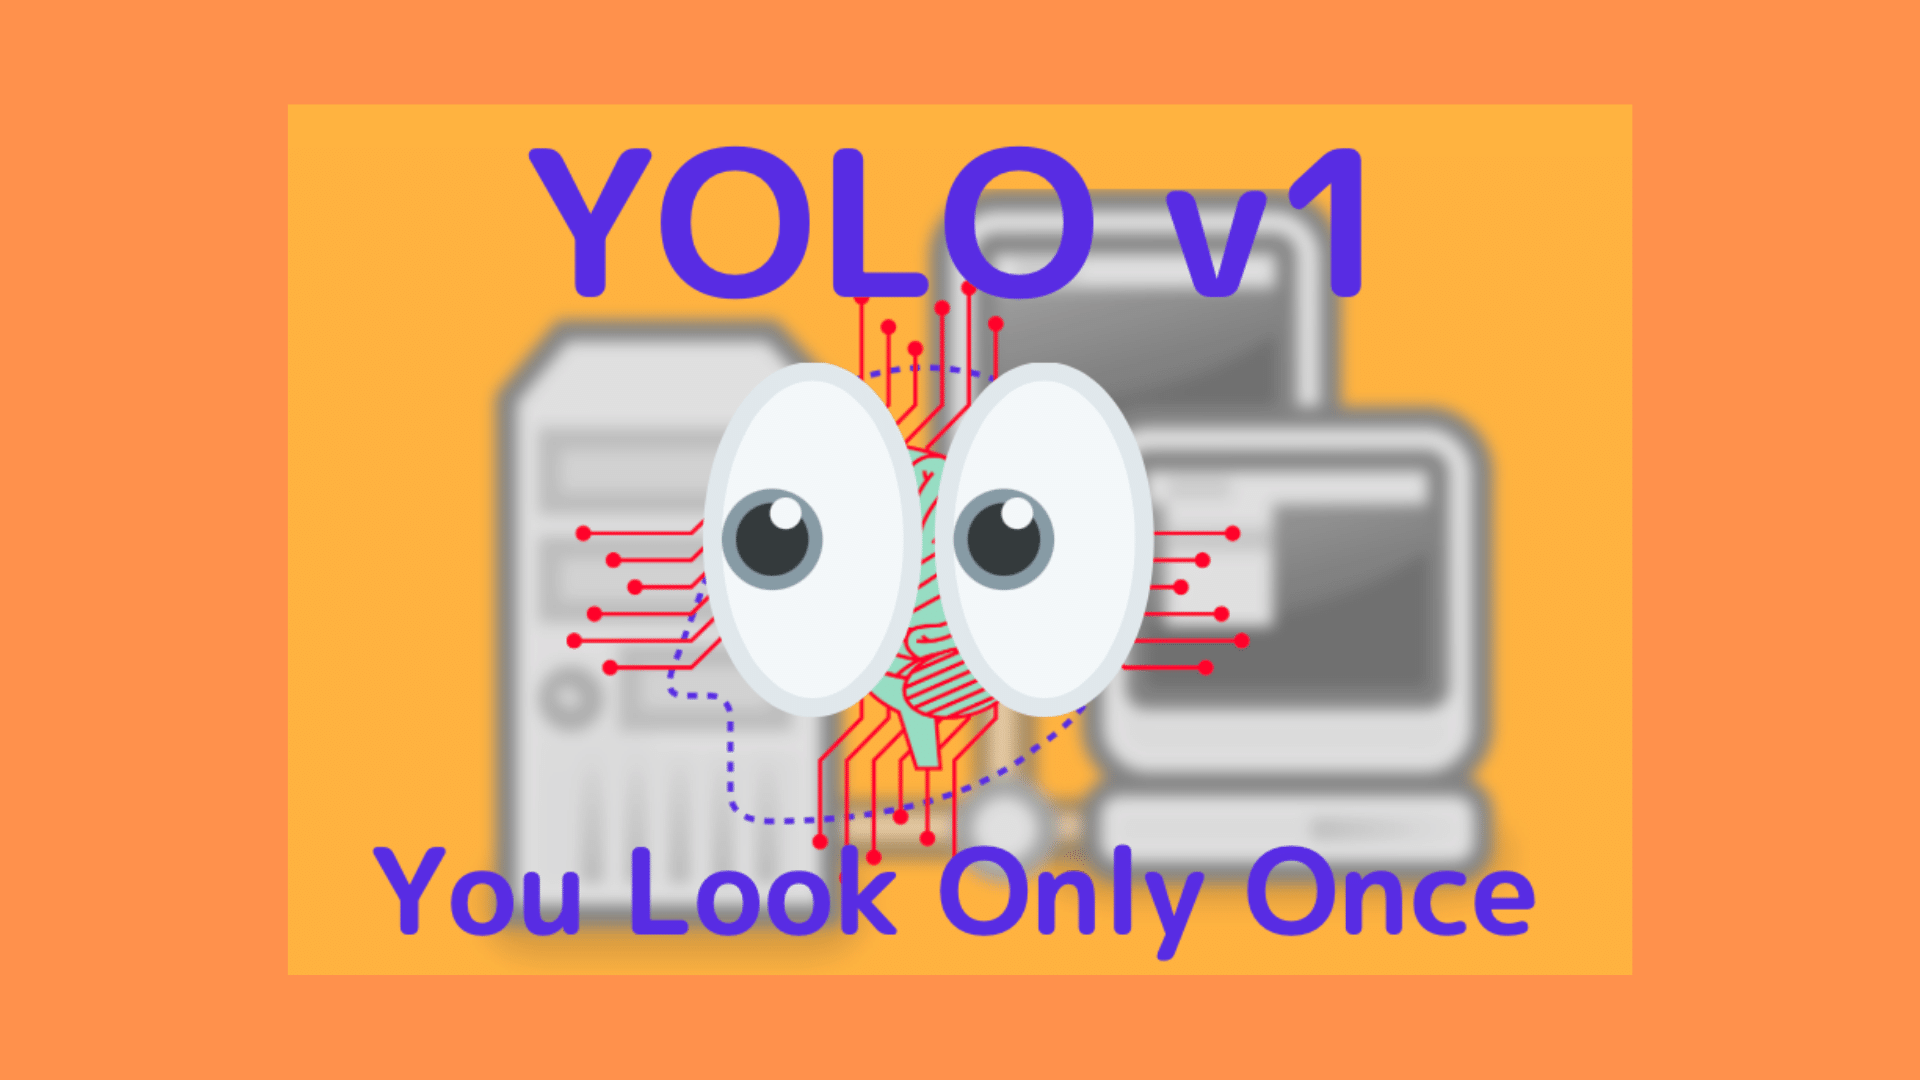

In [31]:
import cv2
import numpy as np
import os
import random
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torch
from tqdm.auto import tqdm
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
import random
import shutil
from torch.optim.lr_scheduler import StepLR
subset = False

# **DATASET DOWNLOAD**

In [ ]:
# downlad pascal voc dataset from roboflow in yolov8 format

# DOWNLOAD THE DATSET FROM HERE -> https://universe.roboflow.com/microsoft/coco
# YOU WILL GET A LINK LIKE THIS
!curl  -L "https://public.roboflow.com---------------------" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [7]:
os.makedirs("train1/images")
os.makedirs("train1/labels")


In [3]:
# we are training on small subset of pascal voc data .... if you want to train with full dataset ignore this part
sample_size = 5000
img = random.sample(os.listdir("/content/train/images"),sample_size)
subset = True

In [8]:
for images in img:
  shutil.copy(f"/content/train/images/{images}","/content/train1/images")
  txt = f"{os.path.splitext(images)[0]}.txt"
  shutil.copy(f"/content/train/labels/{txt}","/content/train1/labels")

print(f"subset Images : {len(os.listdir('/content/train1/images'))}")
print(f"subset Labels : {len(os.listdir('/content/train1/labels'))}")

# **CONFIG**

In [33]:
# CONFIG

classList = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
cell_GT  = (1 * 5) + len(classList)
rows = 7
cols = 7
cell_H = int(448 // 7)
cell_W = int(448 // 7)
pred_len =  (2 * 5) + len(classList)

if subset:
  train_images_path = "/content/train1/images"
  train_labels_path = "/content/train1/labels"
else:
  train_images_path = "/content/train/images"
  train_labels_path = "/content/train/labels"

test_images_path = "/content/valid/images"
test_labels_path = "/content/valid/labels"

IMAGE_SIZE = (448 , 448)

device = "cuda" if torch.cuda.is_available() else "cpu"

### model config

BATCH = 32
coord = 5
noobj = .5
momentum = 0.9
weight_decay = 0.0005
initial_lr = 1e-3
max_lr = 1e-2
epochs_ramp_up = 5
epochs_max_lr = 75
epochs_mid_lr = 30
epochs_low_lr = 30
total_epochs = epochs_ramp_up + epochs_max_lr + epochs_mid_lr + epochs_low_lr
iou_thresholds = [0.5]
"________________________________________________"


print(f"device : {device}")
print(f"prediction cell values : {pred_len}")
print(f"each cell values : {cell_GT}")
print(f"Batch size : {BATCH}")
print(f"total epochs : {total_epochs}")



device : cuda
prediction cell values : 30
each cell values : 25
Batch size : 32
total epochs : 140


# **DATA PREPROCESS**

In [24]:
# DATA PREPROCESSING

class DataCreation(Dataset):
    def __init__(self, image_dir, txt_dir, transform=None, new_size=(448, 448)):
        self.images_path = image_dir
        self.txt_path = txt_dir
        self.list_images = os.listdir(self.images_path)
        self.list_txt = os.listdir(self.txt_path)
        self.transform = transform
        self.new_size = new_size

    def __len__(self):
        return len(self.list_images)

    def __getitem__(self, index):
        output_shape = np.zeros((rows, cols, cell_GT))

        path = os.path.join(self.images_path, self.list_images[index])
        txt_path = f'{os.path.join(self.txt_path, path.split("/")[-1].split(".jpg")[0])}.txt'

        image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        H, W, C = image.shape
        pil_image = Image.fromarray(image)
        resize_transform = transforms.Resize(self.new_size)
        resized_image = resize_transform(pil_image)


        scale_x = self.new_size[0] / W
        scale_y = self.new_size[1] / H

        if self.transform:
            resized_image = self.transform(resized_image)

        # Read and adjust bounding box coordinates
        with open(txt_path, "r") as f:
            coor = f.readlines()
            for c in coor:
                c = c.split()
                cls, x, y, w, h = int(c[0]), float(c[1]), float(c[2]), float(c[3]), float(c[4])

                # Adjust coordinates according to the new image size
                x = x * W * scale_x / self.new_size[0]
                y = y * H * scale_y / self.new_size[1]
                w = w * scale_x
                h = h * scale_y

                x = min(max(x, 0), 1)
                y = min(max(y, 0), 1)

                g_x = int(x * rows)
                g_y = int(y * cols)

                # Get relative X and Y coordinates
                relative_X = (x * rows) - g_x
                relative_y = (y * cols) - g_y

                relative_X = min(max(relative_X, 0), 1)
                relative_y = min(max(relative_y, 0), 1)

                # W, H already normalized by labelImg
                norm_W = w
                norm_H = h
                norm_W = min(max(norm_W, 0), 1)
                norm_H = min(max(norm_H, 0), 1)

                if output_shape[g_x, g_y, 4] == 0:
                    output_shape[g_x, g_y, 0:5] = [relative_X, relative_y, norm_W, norm_H, 1.0]
                    output_shape[g_x, g_y, 5 + int(cls)] = 1.0

        # Convert the resized image to a tensor if not already transformed
        if not self.transform:
            resized_image = transforms.ToTensor()(resized_image)

        output_shape = torch.tensor(output_shape, dtype=torch.float32)
        return resized_image, output_shape






In [23]:
# I didn't do any augmentations, if you want you can add.

transform_ = transforms.Compose([transforms.ToTensor()])

train_data = DataCreation(train_images_path,train_labels_path,transform_,IMAGE_SIZE)
test_data = DataCreation(test_images_path,test_labels_path,transform_,IMAGE_SIZE)


train_dataloader = DataLoader(train_data,batch_size=BATCH,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH,shuffle=False)

# **ARCHITECTURE**

In [26]:
# I am using resnet50 here, you can use any pretrain model or build yolov1 architecture.


class Yolov1(nn.Module):
    def __init__(self,in_c=3,num_class=20):
        super().__init__()

        self.model = resnet50(weights=ResNet50_Weights.DEFAULT)

        for param in self.model.parameters():
          param.requires_grad = False


        self.model = nn.Sequential(*(list(self.model.children())[:-2]))

        self.model1 = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(1024,1024, kernel_size=3, stride=2, padding=1),   # (Ch, 14, 14) -> (Ch, 7, 7)
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Flatten(),
            nn.Linear(7 * 7 * 1024, 4096),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(4096, 7*7*((5*2)+ num_class))
        )

    def forward(self,x):

        x = self.model1(self.model(x))
        return x

In [27]:
# test
a = torch.randn(1,3,448,448).to(device)
model = Yolov1(num_class=len(classList)).to(device)
print(model(a).shape)

torch.Size([1, 1470])


# IOU **calculation**

In [35]:
def intersection_over_union(boxes_preds, boxes_labels, box_format='midpoint'):

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

# **utils**

In [36]:

def mean_average_precision(true_bboxs, pred_bboxs, iou_thresholds):

  precision_and_recall_ = {}
  ap = {}
  for thresh in iou_thresholds:
    meta = {}
    meta_pred = {}
    meta_true = {}
    true_track = set()
    pd_track = set()

    for true_bbox in true_bboxs:

      # here we are tracking gt with cls # 1 : {"TP":0,"FP":0,"FN":0,"GT":0}
      if true_bbox[-1] not in meta:
        meta[true_bbox[-1]] = {"TP":0,"FP":0,"FN":0,"GT":0}
        meta[true_bbox[-1]]["GT"] = 1

      else:
        meta[true_bbox[-1]]["GT"] += 1


      for pred_bbox in pred_bboxs:

        if true_bbox[0] == pred_bbox[0]: # batch idx

          iou = intersection_over_union1(true_bbox[1:5],pred_bbox[1:5]) #checking iou here

          # print(iou)
          if iou >= thresh and true_bbox[-1] == pred_bbox[-1]: # if iou > = thresh and classes are same then its a TP and true bbox is not assigned before

            if tuple(true_bbox) not in true_track:

              meta[true_bbox[-1]]["TP"] += 1
              true_track.add(tuple(true_bbox))

            if tuple(pred_bbox) not in pd_track:
              pd_track.add(tuple(pred_bbox))


            else:
                meta[true_bbox[-1]]["FP"] += 1

          elif iou >= thresh and true_bbox[-1] != pred_bbox[-1]:

            meta[true_bbox[-1]]["FP"] += 1

          elif iou <= thresh:
            if true_bbox[-1] != pred_bbox[-1]:
              pass
            else:
              if true_bbox[-1] == pred_bbox[-1]:

                if pred_bbox[-1] not in meta_pred:
                  meta_pred[pred_bbox[-1]] = {tuple(pred_bbox)}
                else:
                  meta_pred[pred_bbox[-1]].add(tuple(pred_bbox))


                if true_bbox[-1] not in meta_true:
                  meta_true[true_bbox[-1]] = {tuple(true_bbox)}
                else:
                  meta_true[true_bbox[-1]].add(tuple(true_bbox))

    true_track = [list(t) for t in true_track]
    pd_track = [list(t) for t in pd_track]



    for a , b in meta_true.items():
      for c in b:
        if list(c) in true_track:
          pass
        else:
          meta[a]["FN"] += 1

    for a , b in meta_pred.items():
      for c in b:
        if list(c) in pd_track:
          pass
        else:
          meta[a]["FP"] += 1

    for cls , metadata in meta.items():
      FN = meta[cls]["GT"] -  meta[cls]["TP"]
      if meta[cls]["FN"] == FN:
        pass
      else:
        meta[cls]["FN"] = FN

      precisions = meta[cls]["TP"] / (meta[cls]["TP"] + meta[cls]["FP"] + 1e-06)
      recalls = meta[cls]["TP"] / (meta[cls]["TP"] + meta[cls]["FN"] + 1e-06)
      if cls not in precision_and_recall_:
        precision_and_recall_[cls] = [precisions]
        precision_and_recall_[cls].append(recalls)
      else:
        precision_and_recall_[cls].append(precisions)
        precision_and_recall_[cls].append(recalls)

  for cls , data in precision_and_recall_.items():
    precision_and_recall_[cls].append(1.0)
    precision_and_recall_[cls].append(0.0)

  # AP calculation
  for cls , data in precision_and_recall_.items():
    p = np.array(data[::2])
    r = np.array(data[1::2])
    AP = np.sum((r[:-1] - r[1:]) * p[:-1])
    ap[cls] = AP

  return ap

In [37]:
def xywh_to_xyxy(bbox):
    """
    Convert (x, y, w, h) format to (x1, y1, x2, y2) format.
    (x, y) is the center of the box.
    """
    x, y, w, h = bbox
    x1 = x - w / 2
    y1 = y - h / 2
    x2 = x + w / 2
    y2 = y + h / 2
    return [x1, y1, x2, y2]



def intersection_over_union1(bbox1, bbox2):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    Bounding boxes are in (x, y, w, h) format.
    """
    bbox1 = xywh_to_xyxy(bbox1)
    bbox2 = xywh_to_xyxy(bbox2)

    # Intersection coordinates
    inter_x1 = max(bbox1[0], bbox2[0])
    inter_y1 = max(bbox1[1], bbox2[1])
    inter_x2 = min(bbox1[2], bbox2[2])
    inter_y2 = min(bbox1[3], bbox2[3])

    # Compute the area of the intersection rectangle
    inter_width = max(0, inter_x2 - inter_x1)
    inter_height = max(0, inter_y2 - inter_y1)
    inter_area = inter_width * inter_height

    # Compute the area of both the prediction and ground-truth rectangles
    area1 = abs((bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1]))
    area2 = abs((bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1]))

    # Compute the union area
    union_area = area1 + area2 - inter_area

    # Compute the IoU, adding a small epsilon to avoid division by zero
    iou_score = inter_area / (union_area + 1e-06)
    return iou_score

# non max supression
def nms(bbox, conf_threshold , iou_threshold):
    bbox_sorted = [i for i in bbox if i[4] > conf_threshold]
    bbox_sorted = sorted(bbox_sorted,key =lambda x : x[4],reverse=True)
    nms_bbox = []

    while len(bbox_sorted) > 0:
        highest_conf_bbox = bbox_sorted.pop(0)
        nms_bbox.append(highest_conf_bbox)
        for bboxs in bbox_sorted.copy():
            if bboxs[-1] == highest_conf_bbox[-1]:

                # print(bboxs,highest_conf_bbox)

                b1 = [bboxs[0],bboxs[1],bboxs[2],bboxs[3]]
                b2 = [highest_conf_bbox[0],highest_conf_bbox[1],highest_conf_bbox[2],highest_conf_bbox[3]]

                ious = intersection_over_union1(b1,b2)
                if ious >= iou_threshold:
                    bbox_sorted.remove(bboxs)



    return nms_bbox

# changing relative xy to absolute xy wrt Image
def relative_coor_to_absolute(bbox):
  cell_indices = torch.arange(7).repeat(bbox.shape[0], 7, 1).unsqueeze(-1).to(device)
  bbox[...,0:1] = (bbox[...,0:1] + cell_indices.permute(0,2,1,-1)) / 7
  bbox[...,1:2] = (bbox[...,1:2] + cell_indices) / 7
  return bbox

In [38]:
# Learning rate scheduler
def lr_lambda(epoch):
    if epoch < epochs_ramp_up:
        return initial_lr + (max_lr - initial_lr) * (epoch / epochs_ramp_up)
    elif epoch < epochs_ramp_up + epochs_max_lr:
        return max_lr
    elif epoch < epochs_ramp_up + epochs_max_lr + epochs_mid_lr:
        return 1e-3
    else:
        return 1e-4


# **MSE LOSS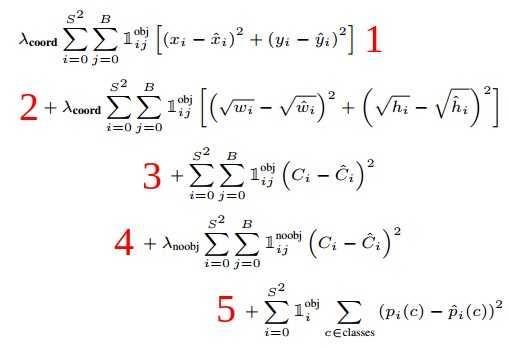**

In [44]:


# loss explain

"""

"obj_present" IS A BINARY MASK WE WILL CALCULATE XYWH LOSS ONLY WHERE OBJECT IS PRESENT IN GT

----- X Y ------
1 = Mseloss(mse,ground_truth[...,0:1][obj_present],best_bbox_pred[...,0:1][obj_present].clone())
1 = Mseloss(mse,ground_truth[...,1:2][obj_present],best_bbox_pred[...,1:2][obj_present].clone())


----- W H ------
best_bbox_pred[...,2:4] = torch.sign(best_bbox_pred[...,2:4].clone()) * torch.sqrt(torch.abs(best_bbox_pred[...,2:4].clone()))
2 = Mseloss(mse,torch.sqrt(ground_truth[...,2:3][obj_present]),best_bbox_pred[...,2:3][obj_present])
2 = Mseloss(mse,torch.sqrt(ground_truth[...,3:4][obj_present]),best_bbox_pred[...,3:4][obj_present])

----- OBJECT LOSS ------
3 = Mseloss(mse,objectness_truth[obj_present],best_conf[obj_present])


IF NO OBJECT IS PRESENT IN THE GRID, WE WILL ONLY CALCULATE CONF SCORE

----- NO OBJECT LOSS ------
4 = Mseloss(mse,objectness_truth[no_obj_present],bbox1_objscore_pred[no_obj_present])
4 = Mseloss(mse,objectness_truth[no_obj_present],bbox2_objscore_pred[no_obj_present])

----- CLASS LOSS ------
5 = torch.sum((class_list - class_truth )**2,dim=-1,keepdim=True)
5 = torch.sum(class_loss_[obj_present])

"""

def Mseloss(mse,true,pred):
  f_t = true
  f_p = pred
  return  mse(f_p,f_t)


# **PREDICT**

In [42]:

def predict(path,epoch):
  t = transforms.Compose([transforms.ToTensor()])
  cim = cv2.resize(cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2RGB),(448,448))

  model.eval()
  with torch.inference_mode():

      t = t(cim).unsqueeze(0)
      pred = model(t.to(torch.float).to(device))

      pred = pred.view(pred.shape[0],7,7,-1)
      class_list = pred[...,10:]
      max_pred_class_grid , index = torch.max(torch.softmax(class_list,dim=-1),dim=-1,keepdim=True)
      bbox1_pred = pred[...,0:4]
      bbox1_objscore_pred = pred[...,4:5]
      bbox2_pred = pred[...,5:9]
      bbox2_objscore_pred = pred[...,9:10]


      bbox1_pred = torch.cat((bbox1_pred,bbox1_objscore_pred),dim=-1)
      bbox2_pred = torch.cat((bbox2_pred,bbox2_objscore_pred),dim=-1)

      concat = torch.cat((bbox1_objscore_pred ,bbox2_objscore_pred),dim=-1)
      best_box_objectness_score  , index_ = torch.max(concat,dim=-1,keepdim=True)

      mask = (index_ == 0).float()
      best_bbox = mask * bbox1_pred + (1 - mask) * bbox2_pred
      best_bbox = torch.cat((best_bbox,index),dim=-1)


      best_bbox = relative_coor_to_absolute(best_bbox)
      masking = torch.where(best_bbox[...,4:5] > .50,1,0)
      best_bbox =  best_bbox * masking
      best_bbox = best_bbox.view(best_bbox.shape[0],7 * 7 , -1)
      batch_size = best_bbox.shape[0]



      all_boxes_pred = []
      pred_bbox = []
      train_idx = 0

      for batch in range(batch_size):
        bbox_ = []
        for i in range(7*7):
          bbox_.append([j.item()for j in best_bbox[batch,i,:]])

        all_boxes_pred.append(bbox_)




      # # if i have 16 batch , then it will go one by one image then check for conf then sorted the bbox according to conf ..high to lower
      for idx in range(batch_size):
        nms_boxes = nms(all_boxes_pred[idx],0.50,0.30,)
        for pred in nms_boxes:
          pred_bbox.append([train_idx] + pred)


        train_idx += 1


      print(len(pred_bbox),pred_bbox)
      for bbox in pred_bbox:
        _ , x,y,w,h,conf,c = bbox
        x1 = int((x - w/2)*448)
        y1 = int((y - h/2)*448)
        x2 = int((x + w/2)*448)
        y2 = int((y + h/2)*448)
        cv2.rectangle(cim,(x1,y1),(x2,y2),(255,0,0),2)
        cv2.putText(cim,f"{round(conf,2)} {classList[int(c)]}",(x1,y1-10),cv2.FONT_HERSHEY_PLAIN,1.2,(0,0,255),2)

  cv2.imwrite(f"image{epoch}.jpg",cv2.cvtColor(cim,cv2.COLOR_RGB2BGR))
  print(f"-> Image saved as: image{epoch}.jpg")

In [ ]:
# predict on a image
predict("/content/valid/images/2007_000039_jpg.rf.eb878cf899cc46bcc3a2d91c6dfede0d.jpg",11)

# **TRAINING**

In [ ]:
best_loss = float('inf')
model = Yolov1(num_class=len(classList)).to(device)
mse = torch.nn.MSELoss(reduction="sum")
optimizer = optim.Adam(model.parameters(),lr=0.0001,weight_decay=0.005,)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

nan = False
map = 0
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# training starts from here
for epochs in range(total_epochs):
  loss = 0.0
  aps = []
  x_y = 0.0
  w_h = 0.0
  cls_loss = 0.0
  obj_loss = 0.0
  no_obj_loss = 0.0
  model.train()
  for im , bbox in tqdm((train_dataloader)):

      optimizer.zero_grad()
      pred = model(im.to(device))  # changing model location to  gpu
      batch = bbox.shape[0]

      ground_truth = bbox.to(device)
      objectness_truth  = ground_truth[...,4:5] #GT objectness score
      class_truth = ground_truth[...,5:] # GT class (ONE HOT ENCODED VECTOR)

      # creating a mask
      obj_present = (objectness_truth == 1)
      no_obj_present  = (objectness_truth == 0)


      pred = pred.view(pred.shape[0],7,7,-1)
      class_list = pred[...,10:] # pred class list

      bbox1_pred = pred[...,0:4] # pred bbox1 coor xywh
      bbox1_objscore_pred = pred[...,4:5] # pred bbox1 obj score

      bbox2_pred = pred[...,5:9]# pred bbox2 coor xywh
      bbox2_objscore_pred = pred[...,9:10]# pred bbox2 obj score


      # x and y were wrt to cell, so we are changing x y coor wrt to image, for iou calculation
      g_t = relative_coor_to_absolute(ground_truth[...,0:4].clone())
      p1 =  relative_coor_to_absolute(bbox1_pred.clone())
      p2 =  relative_coor_to_absolute(bbox2_pred.clone())


      # if there is any object it will return iou score, otherwisse it will return 0, as we multiplying with objectness truth
      iou1 = intersection_over_union(p1*objectness_truth,g_t*objectness_truth) # (Bx7x7x4) * (Bx7x7x1)
      iou2 = intersection_over_union(p2*objectness_truth,g_t*objectness_truth)

      # concating last dimenssion
      concat = torch.cat((iou1,iou2),dim=-1) # (b x 7 x 7 x 1) * (b x 7 x 7 x 1) = (b x 7 x 7 x 2)

      #it will return best bbox iou and its index(0,1)
      best_box_objectness_score  , index_ = torch.max(concat,dim=-1,keepdim=True) #(b x 7 x 7 x 1)
      mask = (index_ == 0).float()

      # selecting best bbox and conf
      best_bbox_pred = mask * bbox1_pred + (1 - mask) * bbox2_pred
      best_conf = mask * (bbox1_objscore_pred*iou1) + (1 - mask) * (bbox2_objscore_pred*iou2)


      """
      LOSS calculation
      """
      ## x y loss calculation.. filtering out only object present grids
      mse_x = Mseloss(mse,ground_truth[...,0:1][obj_present],best_bbox_pred[...,0:1][obj_present].clone())
      mse_y = Mseloss(mse,ground_truth[...,1:2][obj_present],best_bbox_pred[...,1:2][obj_present].clone())


      # w h loss calculation.. filtering out only object present grids
      best_bbox_pred[...,2:4] = torch.sign(best_bbox_pred[...,2:4].clone()) * torch.sqrt(torch.abs(best_bbox_pred[...,2:4].clone()))
      mse_w = Mseloss(mse,torch.sqrt(ground_truth[...,2:3][obj_present]),best_bbox_pred[...,2:3][obj_present])
      mse_h = Mseloss(mse,torch.sqrt(ground_truth[...,3:4][obj_present]),best_bbox_pred[...,3:4][obj_present])

      # object loss
      mse_3 = Mseloss(mse,objectness_truth[obj_present],best_conf[obj_present])

      # no object loss... make sure you comapre with both bboxs in grid cells
      mse_4 = Mseloss(mse,objectness_truth[no_obj_present],bbox1_objscore_pred[no_obj_present])
      mse_5 = Mseloss(mse,objectness_truth[no_obj_present],bbox2_objscore_pred[no_obj_present])

      ## class loss
      class_loss_ = torch.sum((class_list - class_truth )**2,dim=-1,keepdim=True)
      class_loss_ = torch.sum(class_loss_[obj_present])

      mse_1 = mse_x + mse_y
      mse_2 = mse_w + mse_h


      # combined loss
      combined_loss =  coord*(mse_1 + mse_2)  + mse_3 + noobj*(mse_4 + mse_5) + class_loss_

      combined_loss /= batch

      combined_loss.backward()
      optimizer.step()

      if torch.isnan(combined_loss):
        nan = True

      loss += combined_loss.item()
      x_y += coord*mse_1.item() / batch
      w_h += coord*mse_2.item() / batch
      cls_loss += class_loss_.item() / batch
      obj_loss += mse_3.item() / batch
      no_obj_loss += noobj*(mse_4.item()+mse_5.item()) / batch


  model.eval()
  with torch.inference_mode():
    for i , (im , bbox) in tqdm(enumerate((test_dataloader))):

      pred = model(im.to(device))

      # ground
      ground_truth = bbox.to(device)
      objectness_truth  = ground_truth[...,4:5] #objectness score
      class_truth = ground_truth[...,5:] # class truth
      _ , index_g = torch.max(class_truth,dim=-1,keepdim=True)

      ground_cat = torch.cat((ground_truth[...,:4] ,objectness_truth,index_g),dim=-1)


      #prediction
      pred = pred.view(pred.shape[0],7,7,-1)
      class_list = pred[...,10:]
      max_pred_class_grid , index = torch.max(class_list,dim=-1,keepdim=True)
      bbox1_pred = pred[...,0:4]
      bbox1_objscore_pred = pred[...,4:5]
      bbox2_pred = pred[...,5:9]
      bbox2_objscore_pred = pred[...,9:10]
      bbox1_pred = torch.cat((bbox1_pred,bbox1_objscore_pred),dim=-1)
      bbox2_pred = torch.cat((bbox2_pred,bbox2_objscore_pred),dim=-1)
      concat = torch.cat((bbox1_objscore_pred ,bbox2_objscore_pred),dim=-1)
      best_box_objectness_score  , index_ = torch.max(concat,dim=-1,keepdim=True)


      mask = (index_ == 0).float()
      best_bbox = mask * bbox1_pred + (1 - mask) * bbox2_pred
      best_bbox = torch.cat((best_bbox,index),dim=-1)


      # relative coor to absolute coor wrt to image
      best_bbox = relative_coor_to_absolute(best_bbox)
      ground_cat = relative_coor_to_absolute(ground_cat)

      best_bbox = best_bbox.view(best_bbox.shape[0],7 * 7 , -1) # ( B , 7 , 7 , 5) -> ( B , 49 , 5)
      ground_cat = ground_cat.view(ground_cat.shape[0],7 * 7 , -1) #( B , 7 , 7 , 5) ->  ( B , 49 , 5)


      batch_size = best_bbox.shape[0]

      all_boxes_pred = []
      all_boxes_true = []
      pred_bbox = []
      true_bbox = []
      train_idx = 0

      # true bbox
      for batch in range(batch_size):
        bbox_ = []
        for i in range(7*7):
          bbox_.append([j.item() for j in ground_cat[batch,i,:]])
        all_boxes_true.append(bbox_)


      # pred bbox
      for batch in range(batch_size):
        bbox_ = []
        for i in range(7*7):
          bbox_.append([j.item()for j in best_bbox[batch,i,:]])

        all_boxes_pred.append(bbox_)



      # if i have 16 batch , then it will go one by one image then check for conf then sorted the bbox according to conf ..high to lower
      for idx in range(batch_size):
        # 1 : [..., ....,]
        nms_boxes = nms(all_boxes_pred[idx],0.30,0.35)
        # for a single image
        for pred in nms_boxes:
          pred_bbox.append([train_idx] + pred)

        for true in all_boxes_true[idx]:
          if true[4] > .30:
            true_bbox.append([train_idx] + true)

        train_idx += 1

      ap = mean_average_precision(true_bbox,pred_bbox,iou_thresholds)
      ap = sum(ap.values())/len(ap)
      aps.append(ap)

  # print(aps)
  scheduler.step()
  loss /= len(train_dataloader)
  x_y /= len(train_dataloader)
  w_h /= len(train_dataloader)
  cls_loss /=  len(train_dataloader)
  obj_loss /= len(train_dataloader)
  no_obj_loss /= len(train_dataloader)
  maps = sum(aps)/len(aps)


  if best_loss > loss:
    best_loss = loss
    torch.save(model.state_dict(), 'model_state_dict_id.pth')
    print(f"New model saved..")



  print(f"epoch:{epochs+1}/{total_epochs}, loss: {loss:.3f}, x_y:{x_y:.3f}, w_h:{w_h:.3f}, cls: {cls_loss:.3f}, obj_loss: {obj_loss:.3f} no obj: {no_obj_loss:.3f}, test_maP: {maps:.3f} ")



  if epochs % 5 == 0:
    predict("/content/valid/images/2007_000039_jpg.rf.eb878cf899cc46bcc3a2d91c6dfede0d.jpg",epochs)


In [ ]:

# model = Yolov1(num_class=len(classList)).to(device)
# model.load_state_dict(torch.load("/content/drive/MyDrive/yolo/model_state_dict_id.pth",map_location=device))


In [ ]:
#/content/valid/images/2008_007837_jpg.rf.915a5604d236ab01673613417098d136.jpg
#/content/valid/images/2008_008395_jpg.rf.77e90ea8e6fc27389a39e1894628b861.jpg
#/content/valid/images/2008_008269_jpg.rf.8ebf244a62cdd8665889b412cd5056b5.jpg

In [ ]:



# pred = xx.unsqueeze(0)


# class_list = pred[...,5:]
# max_pred_class_grid , index = torch.max(torch.softmax(class_list,dim=-1),dim=-1,keepdim=True)
# bbox1_pred = pred[...,0:4]
# bbox1_objscore_pred = pred[...,4:5]
# bbox2_pred = pred[...,0:4]
# bbox2_objscore_pred = pred[...,4:5]



# bbox1_pred = torch.cat((bbox1_pred,bbox1_objscore_pred),dim=-1)
# bbox2_pred = torch.cat((bbox2_pred,bbox2_objscore_pred),dim=-1)

# concat = torch.cat((bbox1_objscore_pred ,bbox2_objscore_pred),dim=-1)
# best_box_objectness_score  , index_ = torch.max(concat,dim=-1,keepdim=True)



# mask = (index_ == 0).float()
# best_bbox = mask * bbox1_pred + (1 - mask) * bbox2_pred
# best_bbox = torch.cat((best_bbox,index),dim=-1)
# # print(best_bbox.view(best_bbox.shape[0],7 * 7 , -1))



# best_bbox = relative_coor_to_absolute(best_bbox)

# masking = torch.where(best_bbox[...,4:5] > .50,1,0)
# best_bbox =  best_bbox * masking

# best_bbox = best_bbox.view(best_bbox.shape[0],7 * 7 , -1)
# # print(best_bbox)
# batch_size = best_bbox.shape[0]

# all_boxes_pred = []
# pred_bbox = []
# train_idx = 0


# # # ##single batch
# for batch in range(batch_size):
#   bbox_ = []
#   for i in range(7*7):
#     bbox_.append([j.item()for j in best_bbox[batch,i,:]])

#   all_boxes_pred.append(bbox_)
#   # print(all_boxes_pred)



# # # # if i have 16 batch , then it will go one by one image then check for conf then sorted the bbox according to conf ..high to lower
# for idx in range(batch_size):
#   nms_boxes = nms(all_boxes_pred[idx],0.50,0.30,)
#   for pred in nms_boxes:
#     pred_bbox.append([train_idx] + pred)


#   train_idx += 1


# # print(len(pred_bbox),pred_bbox)
# for bbox in pred_bbox:
#   _ , x,y,w,h,conf,c = bbox
#   # print(x,y,w,h)
#   x1 = int((x - w/2)*448)
#   y1 = int((y - h/2)*448)
#   x2 = int((x + w/2)*448)
#   y2 = int((y + h/2)*448)
#   print(x1,y1,x2,y2)
#   cv2.rectangle(cim,(x1,y1),(x2,y2),(255,0,0),2)
#   cv2.putText(cim,f"{round(conf,2)} {classList[int(c)]}",(x1,y1-10),cv2.FONT_HERSHEY_PLAIN,1.2,(0,0,255),2)

# cv2.imwrite(f"image{epoch}.jpg",cv2.cvtColor(cim,cv2.COLOR_RGB2BGR))

In [21]:



# image = cv2.imread("/content/valid/images/2007_000039_jpg.rf.eb878cf899cc46bcc3a2d91c6dfede0d.jpg")
# txt = f"/content/valid/labels/2007_000039_jpg.rf.eb878cf899cc46bcc3a2d91c6dfede0d.txt"



# H,W,C = image.shape
# rows = 7
# cols = 7
# output_shape = np.zeros((rows,cols,cell_GT))
# for i in range(cols):
#     cv2.line(image,(64*(i),0),(64*(i),448),(0,0,255),2,cv2.LINE_AA)
#     if i == 6:
#         cv2.line(image,(64*(i+1),0),(64*(i+1),448),(0,0,255),2,cv2.LINE_AA)

# for i in range(rows):
#     cv2.line(image,(0,64*i),(448,64*i),(0,0,255),2,cv2.LINE_AA)
#     if i == 6:
#         cv2.line(image,(0,64*(i+1)),(448,64*(i+1)),(0,0,255),2,cv2.LINE_AA)

# with open(txt,"r") as f:
#             coor = f.readlines()
#             for c in coor:
#                 c = c.split()
#                 cls , x , y , w , h = int(c[0]) , float(c[1]) , float(c[2]) , float(c[3]) , float(c[4])
#                 g_x = int(x * rows)
#                 g_y = int(y * cols)

#                 cv2.circle(image,(int(x*448),int(y*448)),5,(0,255,0),-1)
#                 cv2.circle(image,(int(64*g_x),int(64*g_y)),5,(255,255,0),-1)

#                 relative_X = x * rows - g_x
#                 realtive_y = y * cols - g_y
#                 if output_shape[g_y,g_x,4] == 0:
#                   print(g_y,g_x,relative_X,realtive_y,w,h,1.0)
#                   output_shape[g_y,g_x,0:5] = [realtive_y,relative_X,w,h,1.0]
#                   output_shape[g_y,g_x,5+int(cls)] = 1.0





# cv2.imwrite("test.jpg",image)



3 3 0.48599999999999977 0.4159999999999999 0.376 0.5066666666666667 1.0


True